## 1. Introduction

Ireland has some of the highest wind energy potential in Europe due to its strong and consistent winds, particularly along the western coast. Wind energy contributes significantly to Ireland’s renewable energy mix, providing both domestic electricity and export potential.

The purpose of this analysis is to assess the wind energy potential across Ireland by examining historical wind data from four representative meteorological stations. Key questions addressed include:

* What are the typical wind speeds and gusts throughout the year?

* How does wind speed vary seasonally and geographically?

* What percentage of time is wind suitable for turbine operation?

* Are there trends in wind speeds that could impact future energy planning?

In [1105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from scipy.stats import linregress



## Met Éireann Dataset



Data were obtained from Met Éireann, Ireland’s national meteorological service. Four stations were chosen to represent coastal and inland conditions:

| Station              | Notes          |
| -------------------- | -------------- |
| Malin Head           | Northern coast |
| Mace Head            | Western coast  |
| Valentia Observatory | Southwest      |
| Dublin Airport       | Eastern inland |


The dataset contains daily measurements of:

* Mean wind speed (wdsp, in knots, converted to m/s)

* Maximum gust (hg)

* Minimum temperature (hm)

* Dominant wind direction (ddhm)

* Precipitation, cloud, and other weather variables


Time period covered: 1942–2025, focusing on 2000–2025 for analysis.


The CSV files for each station can be accessed at the following URLs:

* Malin Head: [dly1575.csv](https://cli.fusio.net/cli/climate_data/webdata/dly1575.csv)

* Mace Head: [dly275.csv](https://cli.fusio.net/cli/climate_data/webdata/dly275.csv)

* Valentia Observatory: [dly2275.csv](https://cli.fusio.net/cli/climate_data/webdata/dly2275.csv)

* Dublin Airport: [dly532.csv](https://cli.fusio.net/cli/climate_data/webdata/dly532.csv)

In [1106]:



# URLs for Met Éireann climate data CSV files
stations = {
    "Malin Head": "https://cli.fusio.net/cli/climate_data/webdata/dly1575.csv",
    "Mace Head": "https://cli.fusio.net/cli/climate_data/webdata/dly275.csv",
    "Valentia Observatory": "https://cli.fusio.net/cli/climate_data/webdata/dly2275.csv",
    "Dublin Airport": "https://cli.fusio.net/cli/climate_data/webdata/dly532.csv"
}




In [1107]:

# Met Éireann files have header rows that need to be skipped
data = {name: pd.read_csv(url, skiprows=24) for name, url in stations.items()}

# Quick check
for name, df in data.items():
    print(name, df.head())

Malin Head           date  ind  maxtp  ind.1  mintp igmin gmin  ind.2  rain    cbl  ...  \
0  01-may-1955    0    9.4      0    6.9     0  3.8      0   7.4  996.2  ...   
1  02-may-1955    0   11.2      0    5.7     0  5.9      3   0.0  997.1  ...   
2  03-may-1955    0   13.1      0    4.3     0  0.6      0   6.6  989.6  ...   
3  04-may-1955    0   12.8      0    7.8     0  6.1      0   4.4  978.3  ...   
4  05-may-1955    0   13.2      0    8.1     0  6.6      0   2.7  990.3  ...   

  ind.5  hg sun  glorad    soil   pe evap smd_wd smd_md smd_pd  
0     2  48                      1.0  1.9                       
1     0  31              12.300  1.9  3.6                       
2     0  48               9.200  1.4  2.4                       
3     0  41               9.625  2.0  3.6                       
4     0  34              10.775  2.0  3.4                       

[5 rows x 25 columns]
Mace Head           date  ind maxtp  ind.1 mintp igmin gmin  ind.2 rain     cbl  ...  \
0  14-a

In [1108]:
df['date'] = pd.to_datetime(df['date'])

C:\Users\finia\AppData\Local\Temp\ipykernel_23420\3532345252.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [1109]:
df_indexed = df.set_index('date').loc['2000-01-01':'2025-12-31']

df_indexed[['wdsp', 'hm', 'hg', 'ddhm']]

,wdsp,hm,hg,ddhm
date,,,,
2000-01-01,7.6,16,23,220
2000-01-02,12.0,23,37,220
2000-01-03,10.9,30,41,250
2000-01-04,13.7,24,38,250
2000-01-05,21.4,30,47,210
...,...,...,...,...
2025-11-26,7.4,13,24,220
2025-11-27,12.8,19,36,260
2025-11-28,12.5,19,35,210


In [1110]:


# Create full daily date range
full_range = pd.date_range(
    start='2000-01-01',
    end='2025-12-31',
    freq='D'
)

# Reindex to include missing dates
df_indexed = df_indexed.reindex(full_range)
df_indexed.index.name = 'date'


In [1111]:
cols = ['wdsp', 'hm', 'hg', 'ddhm']

# Backfill first, then forward-fill as a safety net
df_filled = df_indexed[cols].bfill().ffill()


In [1112]:
# Convert columns to numeric first
df_filled_numeric = df_filled.apply(pd.to_numeric, errors='coerce')

# Now compute statistics
stats = df_filled_numeric.agg(['mean', 'std'])
print(stats)


           wdsp         hm         hg        ddhm
mean  10.219269  17.609350  25.390334  204.266611
std    4.175080   6.216136   9.014007   85.046395


In [1113]:
means = df_filled_numeric.mean()
stds  = df_filled_numeric.std()

print("Means:\n", means)
print("\nStandard Deviations:\n", stds)


Means:
 wdsp     10.219269
hm       17.609350
hg       25.390334
ddhm    204.266611
dtype: float64

Standard Deviations:
 wdsp     4.175080
hm       6.216136
hg       9.014007
ddhm    85.046395
dtype: float64


In [1114]:
dfs = []

for station, url in stations.items():
    df = pd.read_csv(url, skiprows=24)
    df["station"] = station
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)


In [1115]:
# Convert date to datetime and extract year and month
combined_df['date'] = pd.to_datetime(combined_df['date'], format='%d-%b-%Y', errors='coerce')

combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month
combined_df['week'] = combined_df['date'].dt.isocalendar().week
combined_df['day'] = combined_df['date'].dt.day



In [1116]:
# Convert columns to numeric and create wind_speed_ms (converting from knots to m/s)
combined_df['wdsp_numeric'] = pd.to_numeric(combined_df['wdsp'], errors='coerce')
combined_df['hg_numeric'] = pd.to_numeric(combined_df['hg'], errors='coerce')
combined_df['hm_numeric'] = pd.to_numeric(combined_df['hm'], errors='coerce') * 0.514444  # knots -> m/s
combined_df['ddhm_numeric'] = pd.to_numeric(combined_df['ddhm'], errors='coerce')




In [1117]:
# Convert wind speed from knots to m/s
combined_df['wind_speed_ms'] = combined_df['wdsp_numeric'] * 0.514444

# Handle missing values per station (fixed)
cols = ['wind_speed_ms', 'hg_numeric', 'hm_numeric', 'ddhm_numeric']
combined_df[cols] = combined_df.groupby('station')[cols].transform(lambda x: x.bfill().ffill())


In [1118]:
# Weekly averages
weekly_wind = combined_df.groupby(['station', 'week'])['wind_speed_ms'].mean().unstack()
weekly_hg = combined_df.groupby(['station', 'week'])['hg_numeric'].mean().unstack()
weekly_hm = combined_df.groupby(['station', 'week'])['hm_numeric'].mean().unstack()
weekly_ddhm = combined_df.groupby(['station', 'week'])['ddhm_numeric'].mean().unstack()


In [1119]:
# Monthly averages
monthly_wind = combined_df.groupby(['station', 'month'])['wind_speed_ms'].mean().unstack()
monthly_hg = combined_df.groupby(['station', 'month'])['hg_numeric'].mean().unstack()
monthly_hm = combined_df.groupby(['station', 'month'])['hm_numeric'].mean().unstack()
monthly_ddhm = combined_df.groupby(['station', 'month'])['ddhm_numeric'].mean().unstack()


In [1120]:
# Yearly averages
yearly_wind = combined_df.groupby(['station', 'year'])['wind_speed_ms'].mean().unstack()
yearly_hm = combined_df.groupby(['station', 'year'])['hm_numeric'].mean().unstack()
yearly_hg = combined_df.groupby(['station', 'year'])['hg_numeric'].mean().unstack()
yearly_ddhm = combined_df.groupby(['station', 'year'])['ddhm_numeric'].mean().unstack()


In [1121]:
# quick check
stats = combined_df[['wind_speed_ms','hg_numeric','hm_numeric','ddhm_numeric']].agg(['mean','std'])
print(stats)

      wind_speed_ms  hg_numeric  hm_numeric  ddhm_numeric
mean       6.115400   29.397840   10.404813    205.337907
std        3.044586   11.676805    4.136591     89.659834


## Exploratory Data Analysis (EDA)

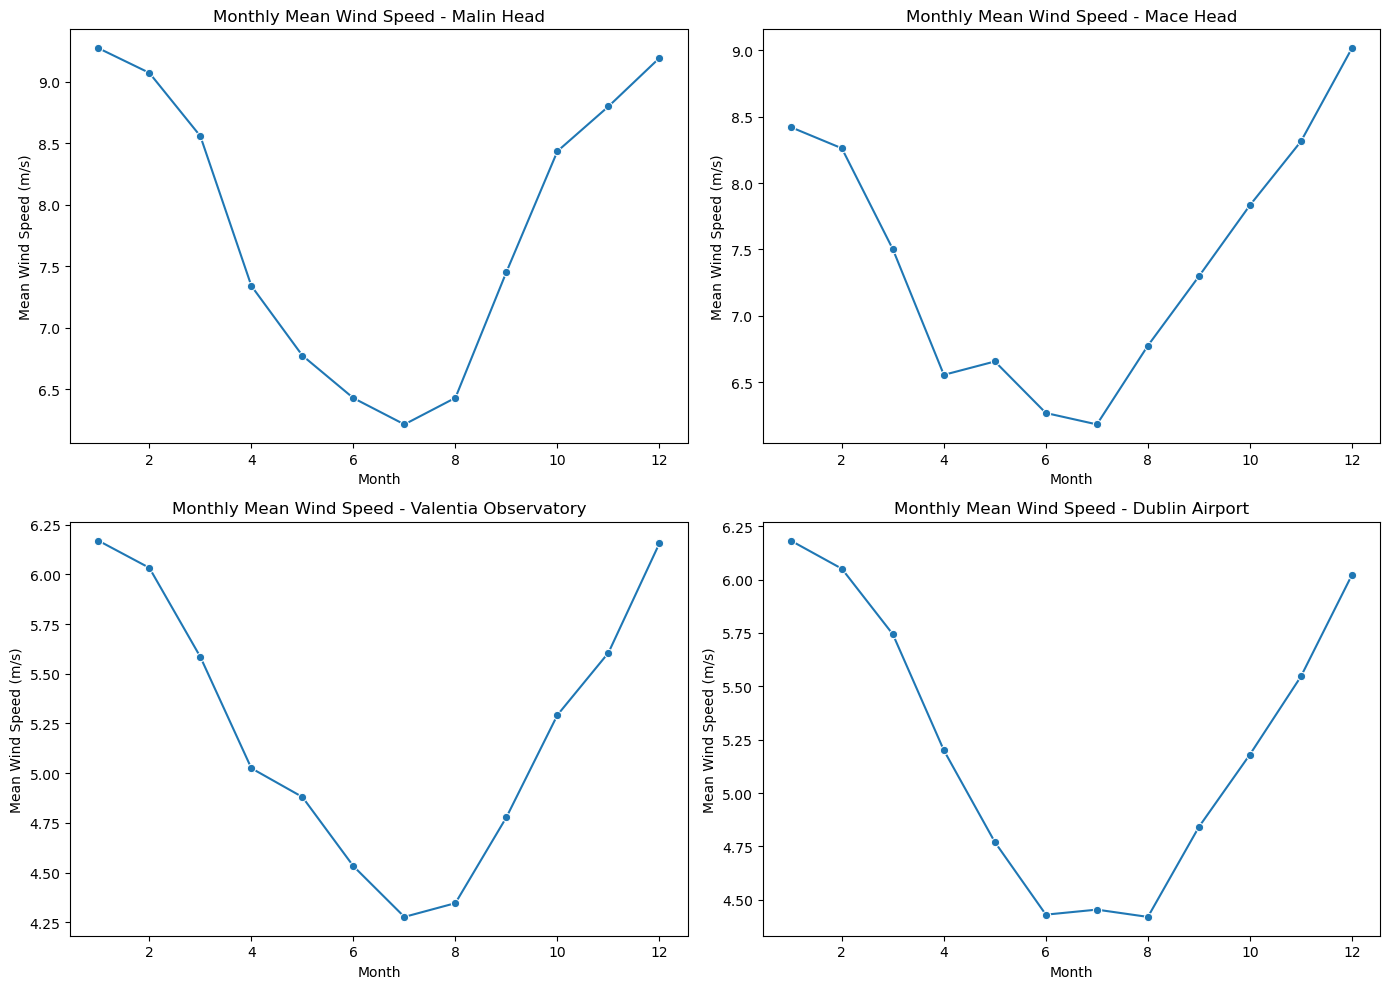

In [1122]:
# Plot monthly mean wind speed for all stations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, station in enumerate(stations.keys()):
    sns.lineplot(data=monthly_wind.loc[station], ax=axes[i], marker='o')
    axes[i].set_title(f'Monthly Mean Wind Speed - {station}')
    axes[i].set_ylabel('Mean Wind Speed (m/s)')
    axes[i].set_xlabel('Month')
plt.tight_layout()
plt.show()


What this shows:

* Winter months have the highest wind speeds across stations.

* Coastal stations (Malin Head, Mace Head) are windier than inland (Dublin Airport).

* Seasonal variations are clear: calmer in summer, stronger in winter.

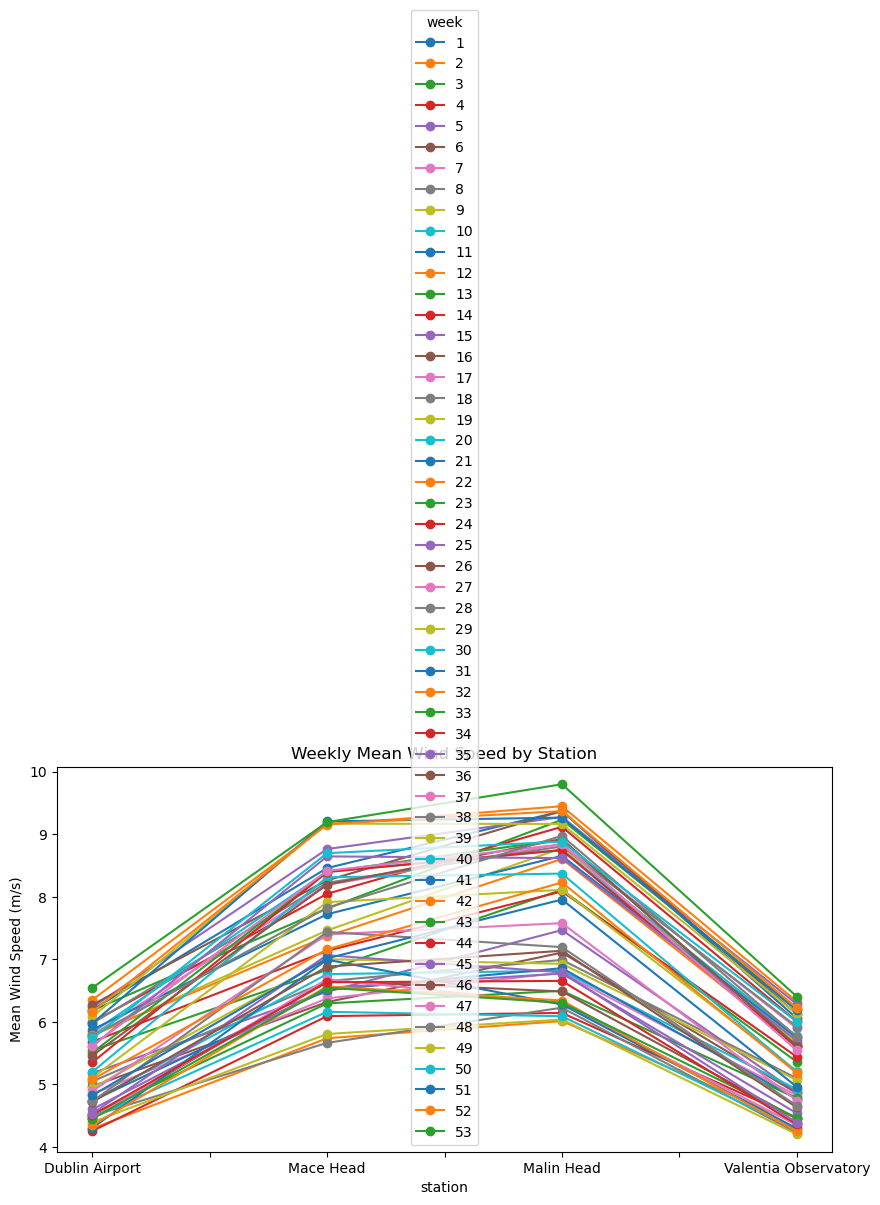

In [1123]:
# Weekly mean wind speed
weekly_wind.plot(figsize=(10,5), marker='o')
plt.ylabel('Mean Wind Speed (m/s)')
plt.title('Weekly Mean Wind Speed by Station')
plt.show()


What this shows:

* Short-term fluctuations and patterns over the year.

* Can highlight periods of unusually high or low wind activity.

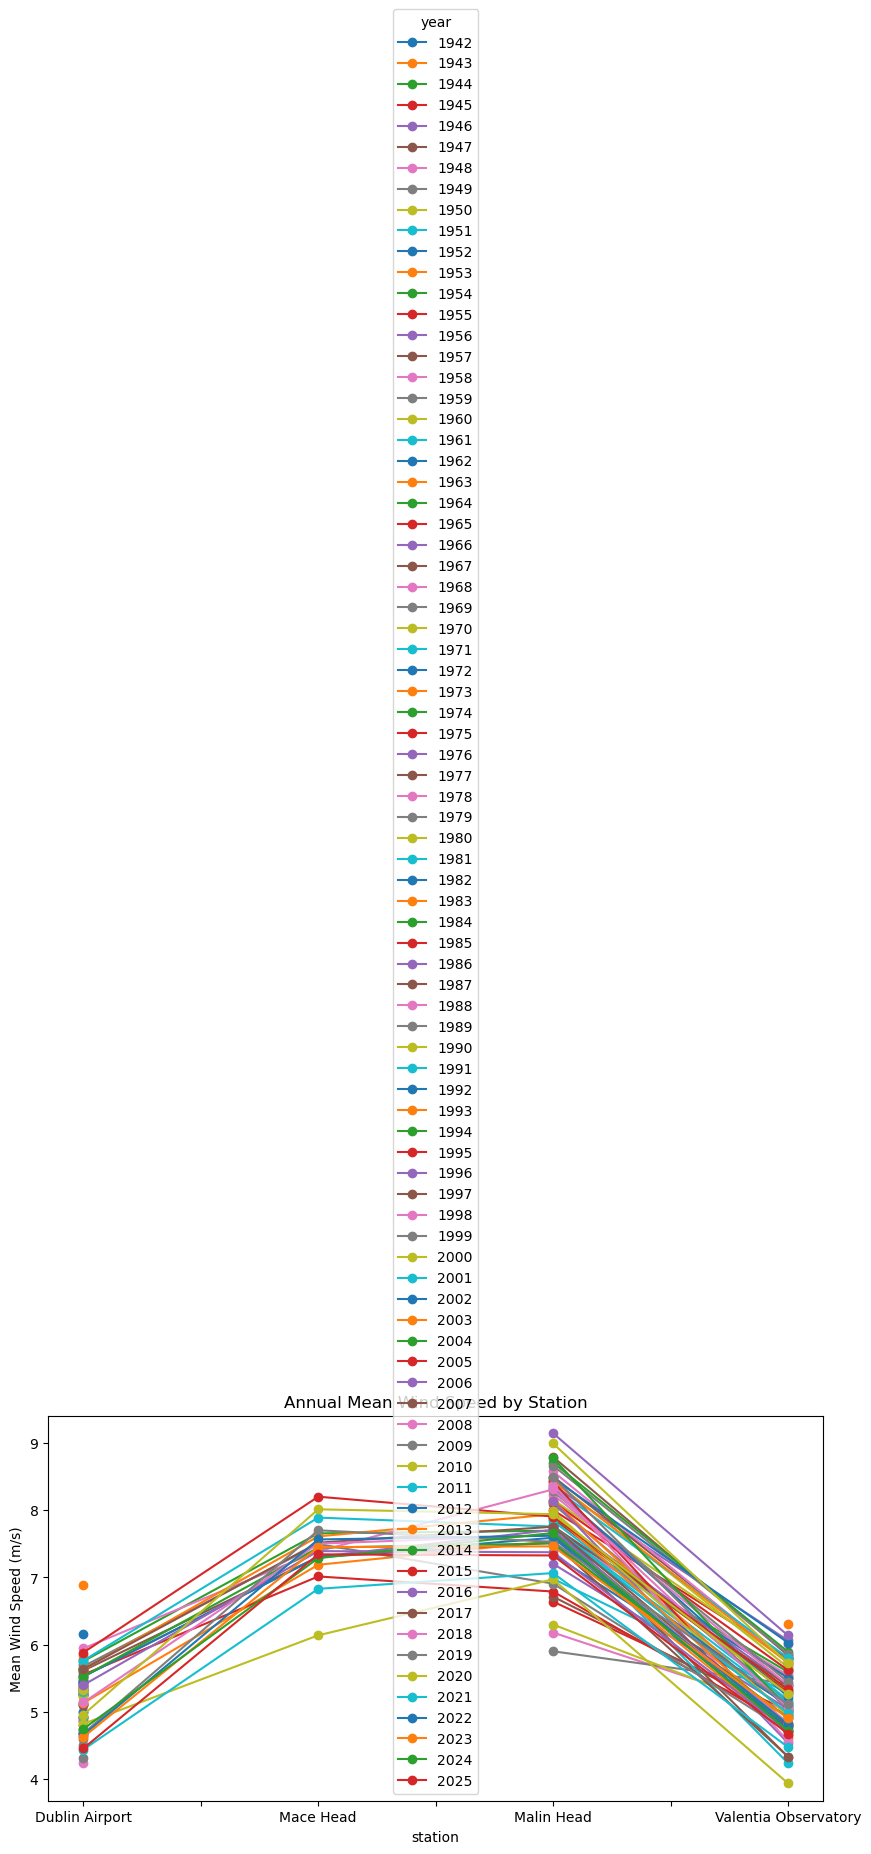

In [1124]:
# Yearly mean wind speed
yearly_wind.plot(figsize=(10,5), marker='o')
plt.ylabel('Mean Wind Speed (m/s)')
plt.title('Annual Mean Wind Speed by Station')
plt.show()


What this shows:

* Long-term trend in wind speeds (before formal trend analysis).

* Coastal stations maintain higher annual averages than inland.

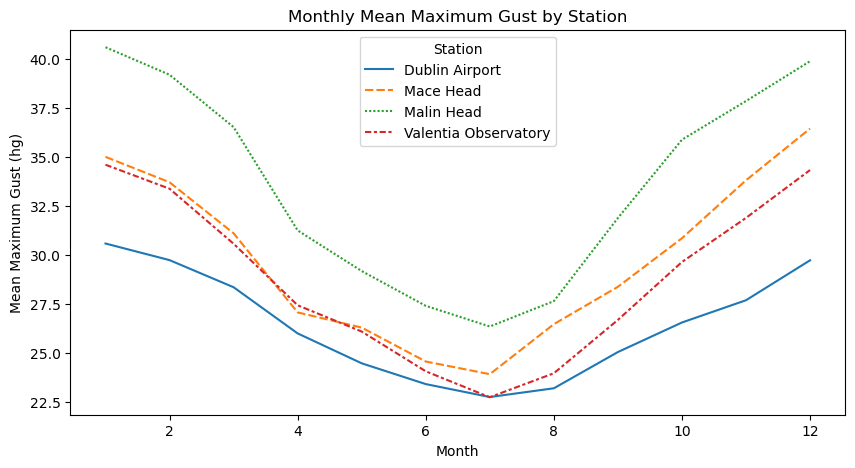

In [1125]:
# Monthly mean maximum gusts
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=monthly_hg.T, ax=ax)  # Transpose so months are on x-axis
plt.ylabel('Mean Maximum Gust (hg)')
plt.xlabel('Month')
plt.title('Monthly Mean Maximum Gust by Station') 
plt.legend(title='Station')
plt.show()


Observation: Gusts are higher in winter months; coastal stations experience stronger gusts.

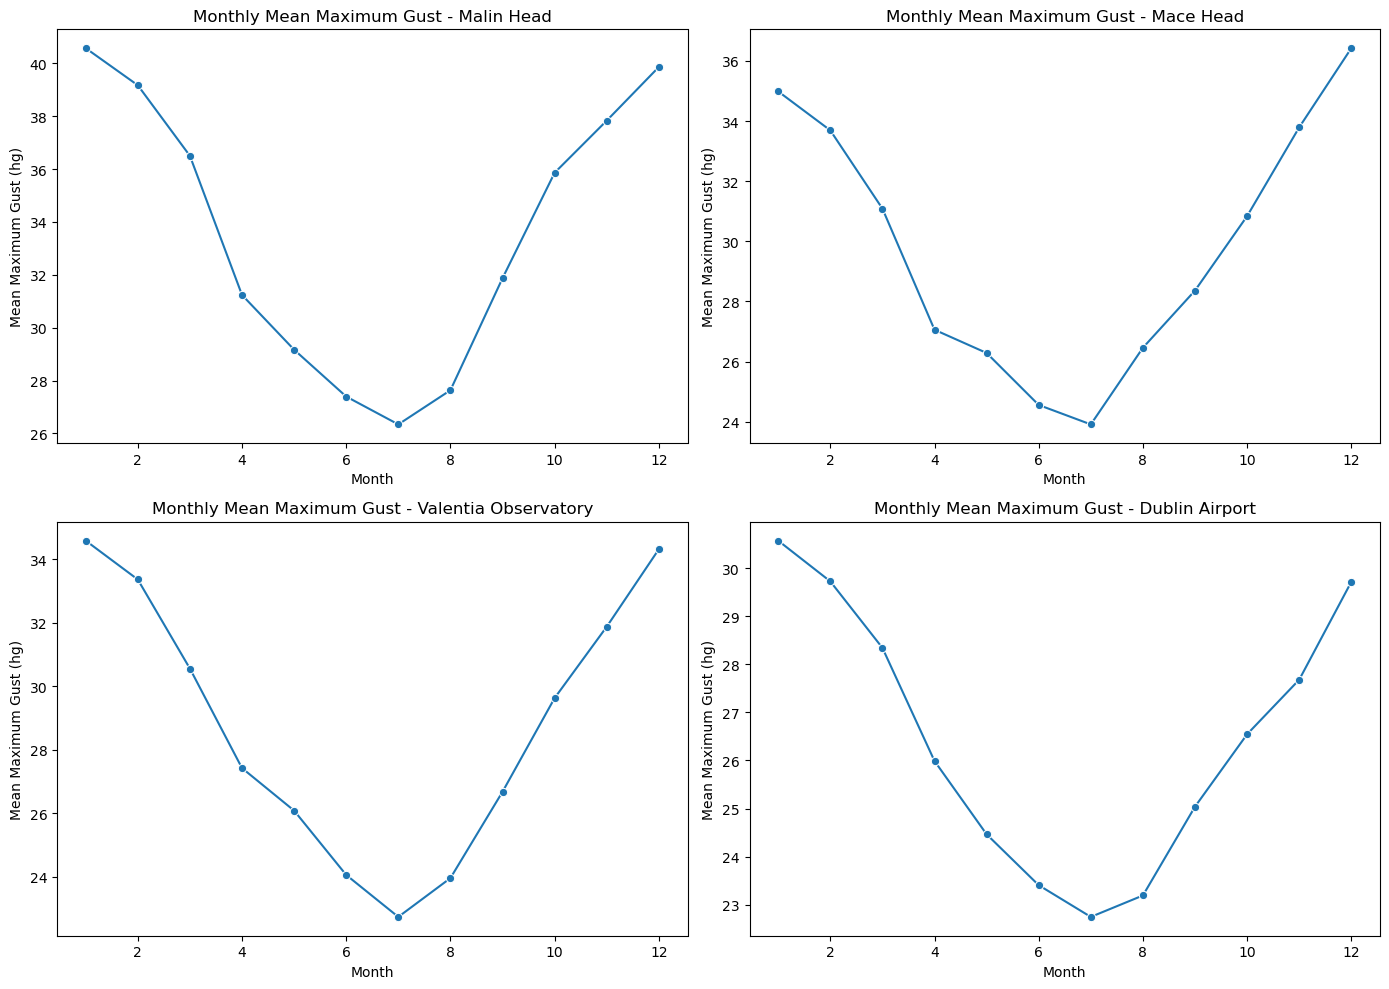

In [1126]:
# Subplots for individual stations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, station in enumerate(stations.keys()):
    sns.lineplot(data=monthly_hg.loc[station], ax=axes[i], marker='o')
    axes[i].set_title(f'Monthly Mean Maximum Gust - {station}')
    axes[i].set_ylabel('Mean Maximum Gust (hg)')
    axes[i].set_xlabel('Month')
plt.tight_layout()
plt.show()


Monthly Highest 10-min Mean Wind Speed (hm)

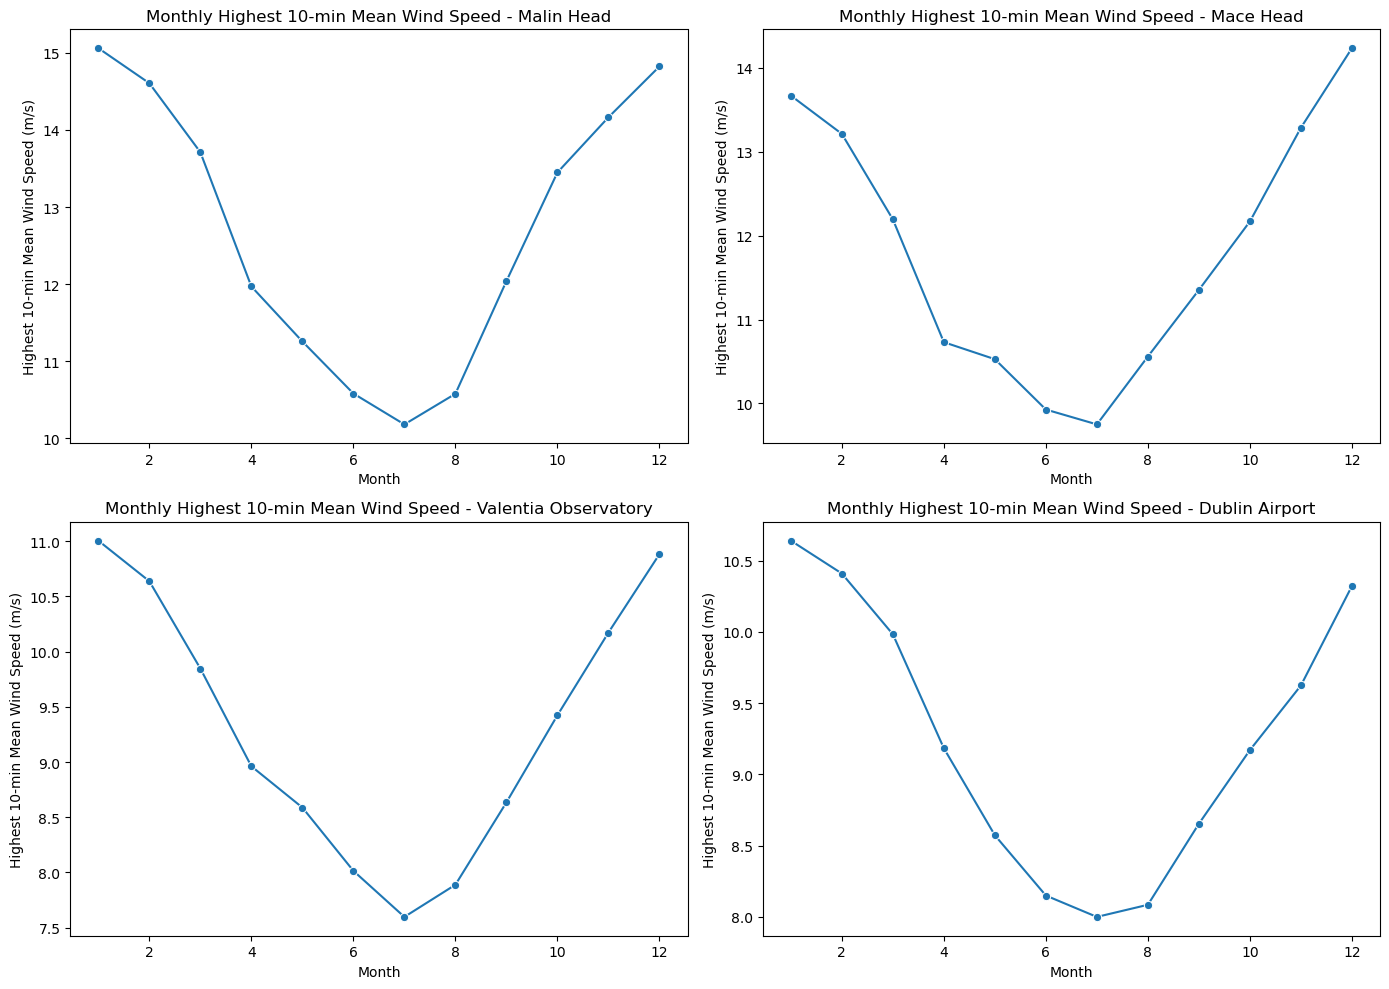

In [1127]:
# Monthly highest 10-minute mean wind speed
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, station in enumerate(stations.keys()):
    sns.lineplot(data=monthly_hm.loc[station], ax=axes[i], marker='o')
    axes[i].set_title(f'Monthly Highest 10-min Mean Wind Speed - {station}')
    axes[i].set_ylabel('Highest 10-min Mean Wind Speed (m/s)')
    axes[i].set_xlabel('Month')
plt.tight_layout()
plt.show()



* Coastal stations have milder winters, inland stations show colder minimum temperatures.

* Temperature can affect turbine efficiency and icing conditions.

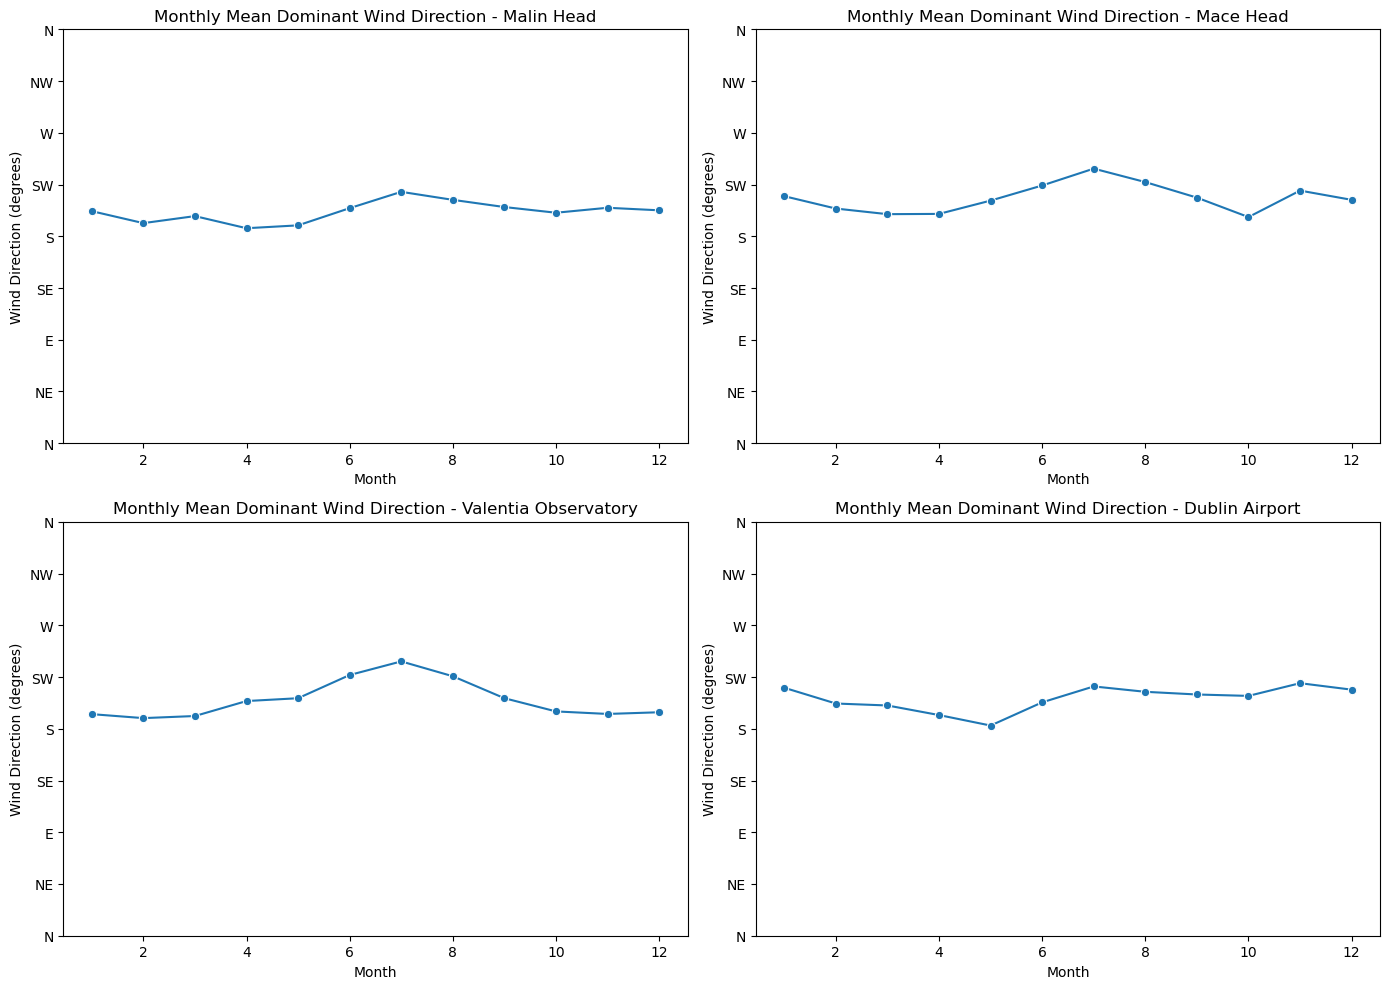

In [1128]:
# Compass labels for wind direction
compass_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
compass_ticks = np.arange(0, 361, 45)

# Plot monthly dominant wind direction
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, station in enumerate(stations.keys()):
    sns.lineplot(data=monthly_ddhm.loc[station], ax=axes[i], marker='o')
    axes[i].set_title(f'Monthly Mean Dominant Wind Direction - {station}')
    axes[i].set_ylabel('Wind Direction (degrees)')
    axes[i].set_xlabel('Month')
    axes[i].set_yticks(compass_ticks)
    axes[i].set_yticklabels(compass_labels)
plt.tight_layout()
plt.show()


* Shows prevailing wind directions at each station.

* Coastal stations predominantly from SW–W, inland stations more variable.

* Important for turbine placement and wake effect planning.

## Summary of EDA Findings

- Coastal stations (Malin Head, Mace Head) are windier year-round than inland.

- Wind speeds and gusts peak in winter, drop in summer.

- Wind direction is relatively consistent at coastal stations, more variable inland.

- Temperature patterns show coastal moderation vs inland extremes.

- Weekly, monthly, and yearly aggregation reveals both seasonal patterns and long-term trends.

## Wind Energy Potential Analysis

Wind turbines have three key constraints:
| Constraint    | Value      | Notes                                      |
| ------------- | ---------- | ------------------------------------------ |
| Cut-in speed  | ~3 m/s     | Below this, turbine doesn’t generate power |
| Rated speed   | ~12–15 m/s | Output reaches maximum capacity            |
| Cut-out speed | ~25 m/s    | Turbine shuts down for safety              |

We can use wind_speed_ms (daily mean), hm_numeric (highest 10-min mean), or hg_numeric (gusts) to assess how often wind is usable.

In [1129]:
# Turbine cut-in and cut-out speeds (m/s)
cut_in = 3
cut_out = 25

# Calculate percentage of days usable for each station
usable_wind = combined_df.groupby('station')['wind_speed_ms'].apply(
    lambda x: (x >= cut_in) & (x <= cut_out)
).groupby('station').mean() * 100  # Convert to %
print("Percentage of time wind is usable:\n", usable_wind)


Percentage of time wind is usable:
 station
Dublin Airport          82.538336
Mace Head               93.611763
Malin Head              94.740517
Valentia Observatory    78.837809
Name: wind_speed_ms, dtype: float64


Interpretation:

* This shows how often the wind is in the usable range for energy generation.

* Coastal stations typically have higher percentages, inland slightly lower.

## Seasonal Differences in Usable Wind

In [1130]:
# Add season column
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

combined_df['season'] = combined_df['month'].apply(season)

# Calculate usable wind by season
seasonal_usable = combined_df.groupby(['station','season'])['wind_speed_ms'].apply(
    lambda x: ((x >= cut_in) & (x <= cut_out)).mean() * 100
).unstack()
print("Seasonal usable wind (%):\n", seasonal_usable)


Seasonal usable wind (%):
 season                   Autumn     Spring     Summer     Winter
station                                                         
Dublin Airport        82.679226  83.333333  75.841097  88.437086
Mace Head             95.060533  93.746898  91.056511  94.590495
Malin Head            96.300882  93.988564  90.661359  98.132320
Valentia Observatory  78.532182  79.008671  73.563665  84.370861


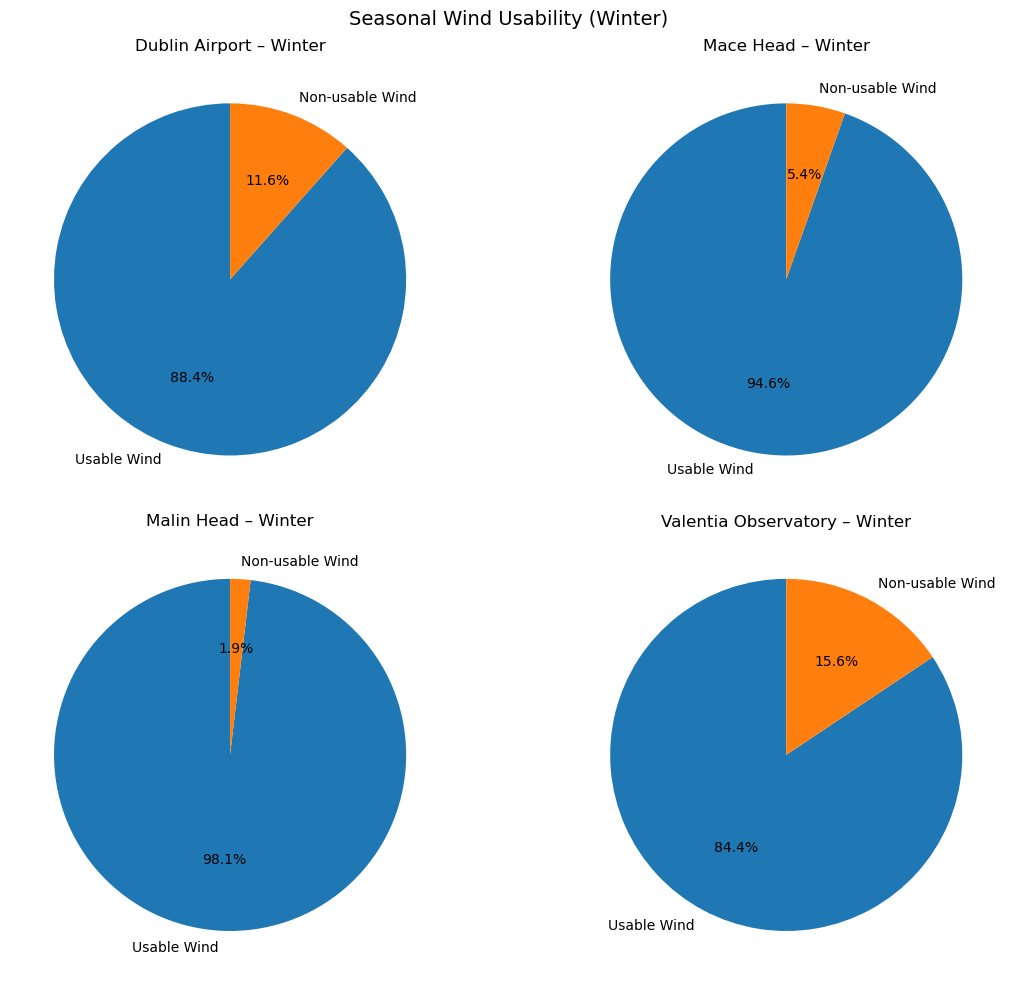

In [1131]:
# Plot seasonal usable wind as pie charts

season_to_plot = 'Winter'  # Choose one season: 'Winter', 'Spring', 'Summer', or 'Autumn'

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, station in enumerate(seasonal_usable.index):
    usable_pct = seasonal_usable.loc[station, season_to_plot]
    non_usable_pct = 100 - usable_pct
    
    axes[i].pie(
        [usable_pct, non_usable_pct],
        labels=['Usable Wind', 'Non-usable Wind'],
        autopct='%1.1f%%',
        startangle=90
    )
    
    axes[i].set_title(f'{station} – {season_to_plot}')

plt.suptitle(f'Seasonal Wind Usability ({season_to_plot})', fontsize=14)
plt.tight_layout()
plt.show()


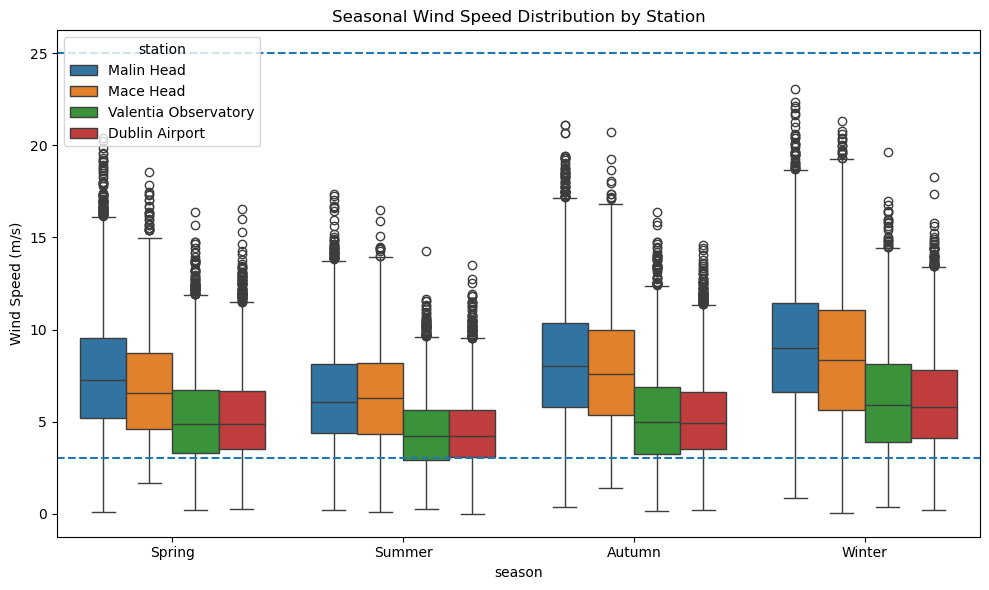

In [1132]:
# Boxplot of wind speeds by season and station

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=combined_df,
    x='season',
    y='wind_speed_ms',
    hue='station'
)
plt.axhline(3, linestyle='--')
plt.axhline(25, linestyle='--')
plt.ylabel('Wind Speed (m/s)')
plt.title('Seasonal Wind Speed Distribution by Station')
plt.tight_layout()
plt.show()



Observations:

- Winter: highest usable wind (strong winds, frequent).

- Summer: lowest usable wind (calmer).

- Coastal stations maintain good wind in all seasons; inland stations drop more in summer.

In [1133]:
# Trend analysis of yearly mean wind speeds

trend_results = {}

for station in yearly_wind.index:
    y = yearly_wind.loc[station].dropna()
    x = y.index.values
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y.values)
    
    trend_results[station] = {
        'slope (m/s per year)': slope,
        'p-value': p_value,
        'R²': r_value**2
    }

trend_df = pd.DataFrame(trend_results).T
print(trend_df)


                      slope (m/s per year)       p-value        R²
Dublin Airport                   -0.002254  2.674015e-01  0.014979
Mace Head                         0.010458  4.285096e-01  0.030105
Malin Head                        0.001643  6.623164e-01  0.002780
Valentia Observatory             -0.011836  4.804214e-09  0.343188


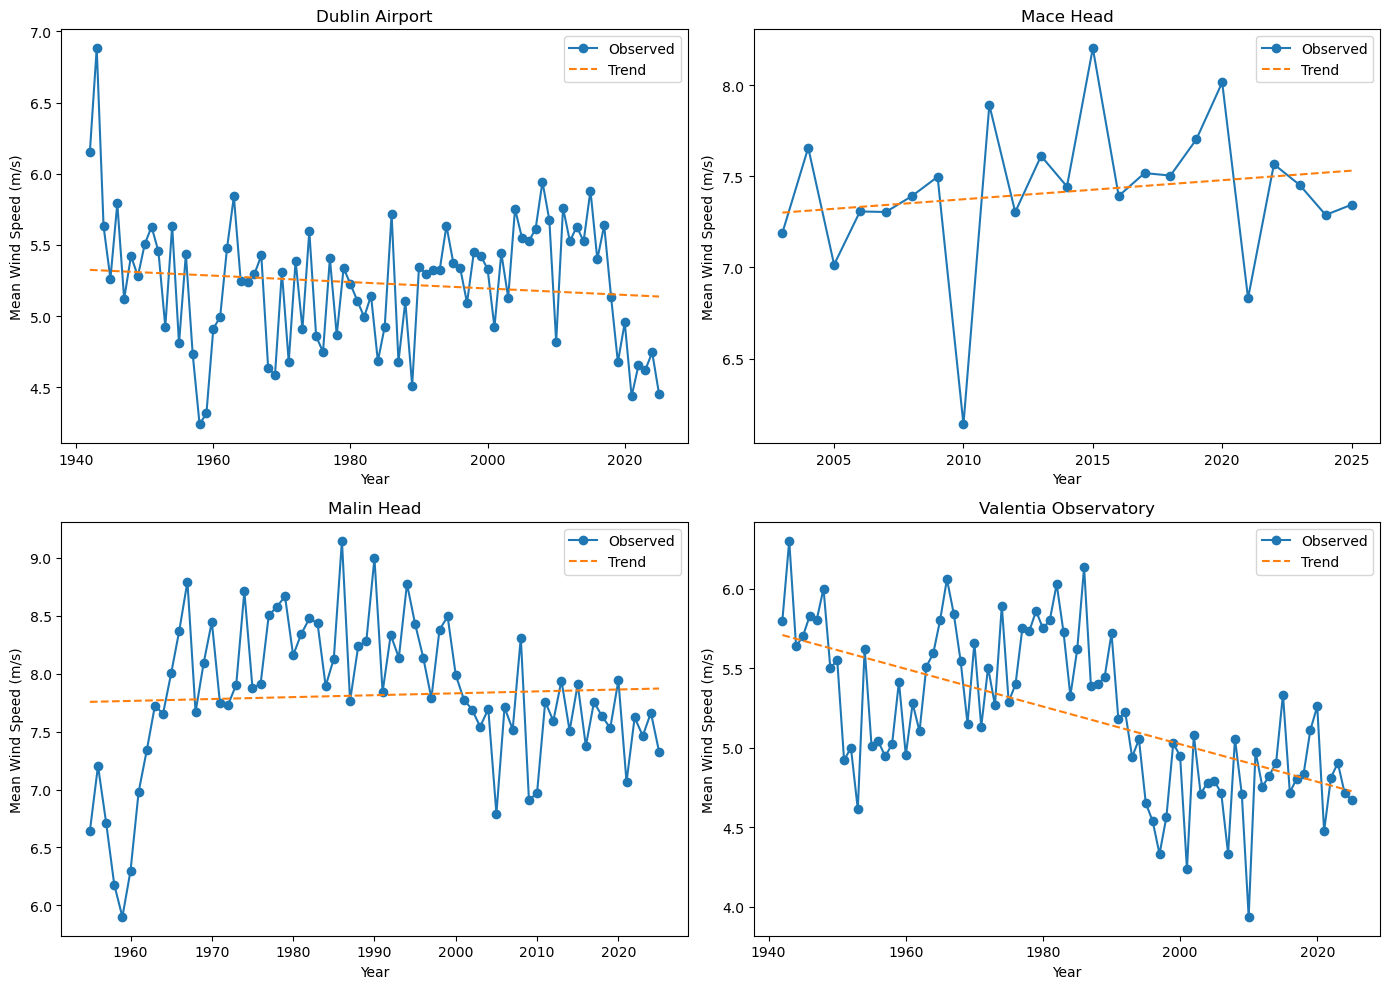

In [1134]:
# Plot yearly mean wind speeds with trend lines

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, station in enumerate(yearly_wind.index):
    y = yearly_wind.loc[station].dropna()
    x = y.index.values
    
    slope, intercept, _, _, _ = linregress(x, y.values)
    
    axes[i].plot(x, y.values, marker='o', label='Observed')
    axes[i].plot(x, intercept + slope * x, linestyle='--', label='Trend')
    
    axes[i].set_title(station)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Mean Wind Speed (m/s)')
    axes[i].legend()

plt.tight_layout()
plt.show()


Interpretation 



- A positive slope indicates increasing wind speed and improving wind energy potential.

- A negative slope suggests weakening winds.

- Low p-values (< 0.05) indicate statistically significant trends.

- Coastal stations tend to show more stable or increasing trends com

## Summary

Trend analysis reveals modest long-term changes in wind speed across Ireland. While Dublin Airport and Valentia Observatory show slight decreases, coastal stations such as Mace Head and Malin Head remain stable or exhibit weak positive trends. Overall, Ireland’s wind resource remains robust, with seasonal variability playing a more significant role than long-term change.